# Loan Approval: Perceptron vs Neural Network

In [2]:
# Imports and dataset loading
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('cia-dataset.csv')

cols = {c.lower(): c for c in df.columns}
credit_col = cols.get('credit_score', None) or next((c for k,c in cols.items() if 'credit' in k), None)
age_col = cols.get('age', None) or next((c for k,c in cols.items() if k=='age' or 'age' in k), None)
emp_col = cols.get('employment_years', None) or next((c for k,c in cols.items() if 'employ' in k), None)
target_col = cols.get('approved', None) or next((c for k,c in cols.items() if 'approv' in k), None)
if not all([credit_col, age_col, emp_col, target_col]):
    raise ValueError('Required columns not found in cia-dataset.csv. Expected: Credit_score, Age, Employment_years, Approved')

X = df[[credit_col, age_col, emp_col]].values.astype(float)
y = df[target_col].values.astype(int)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
print('Loaded', df.shape[0], 'rows; using features:', credit_col, age_col, emp_col)

Loaded 550 rows; using features: credit_score age employment_years


## 1) Single-layer Perceptron

In [3]:
# Simple perceptron implementation (binary classification)
class Perceptron:
    def __init__(self, n_features, lr=0.01, epochs=100):
        self.lr = lr
        self.epochs = epochs
        self.w = np.zeros(n_features + 1)

    def fit(self, X, y):
       
        y_mod = np.where(y==0, -1, 1)
        Xb = np.hstack([np.ones((X.shape[0],1)), X])
        for _ in range(self.epochs):
            for xi, yi in zip(Xb, y_mod):
                activation = np.dot(self.w, xi)
                pred = 1 if activation >= 0 else -1
                if pred != yi:
                    self.w += self.lr * yi * xi

    def predict(self, X):
        Xb = np.hstack([np.ones((X.shape[0],1)), X])
        act = Xb.dot(self.w)
        return (act >= 0).astype(int)


perc = Perceptron(n_features=X_train_s.shape[1], lr=0.01, epochs=100)
perc.fit(X_train_s, y_train)
y_pred_perc = perc.predict(X_test_s)
acc_perc = accuracy_score(y_test, y_pred_perc)
print('Perceptron test accuracy:', round(acc_perc,4))

Perceptron test accuracy: 0.9545


## 2) Feedforward Neural Network 

In [4]:
from sklearn.neural_network import MLPClassifier


y_train_nn = np.asarray(y_train).astype(int)
y_test_nn = np.asarray(y_test).astype(int)

epochs = 50
mlp = MLPClassifier(hidden_layer_sizes=(8,), activation='relu', solver='adam', learning_rate_init=0.001, max_iter=1, warm_start=True, random_state=42)
train_acc = []
val_acc = []
for epoch in range(epochs):
    mlp.fit(X_train_s, y_train_nn)
    train_acc.append(mlp.score(X_train_s, y_train_nn))
    val_acc.append(mlp.score(X_test_s, y_test_nn))
# final test accuracy
test_acc = mlp.score(X_test_s, y_test_nn)
print('Neural network (MLPClassifier) test accuracy:', round(test_acc,4))
# create a history-like dict for plotting
history = {'accuracy': train_acc, 'val_accuracy': val_acc}

Neural network (MLPClassifier) test accuracy: 0.9545


## 3) Compare accuracies


In [5]:
print(f'Perceptron accuracy: {acc_perc:.4f}')
print(f'Neural network (MLPClassifier) accuracy: {test_acc:.4f}')

Perceptron accuracy: 0.9545
Neural network (MLPClassifier) accuracy: 0.9545


## 4) PLOT

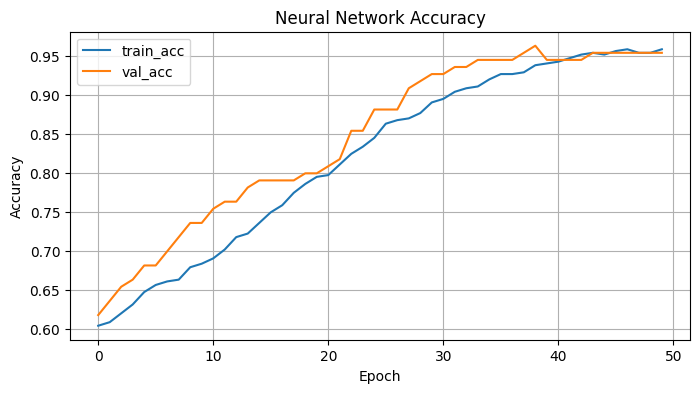

In [6]:
plt.figure(figsize=(8,4))
if hasattr(history, 'history'):
    h_train = history.history.get('accuracy') or history.history.get('acc') or []
    h_val = history.history.get('val_accuracy') or history.history.get('val_acc') or []
else:
    h_train = history.get('accuracy') if isinstance(history, dict) else []
    h_val = history.get('val_accuracy') if isinstance(history, dict) else []
h_train = h_train or []
h_val = h_val or []
plt.plot(h_train, label='train_acc')
plt.plot(h_val, label='val_acc')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 5) Interpretation
- Perceptron: a single-layer perceptron is a linear classifier. It will perform well when the three features (credit score, age, employment years) separate approved vs rejected loans with a linear boundary. If your perceptron accuracy is lower, the data likely contains nonlinear patterns or interactions the perceptron cannot capture.
- MLP (neural network): the MLP with one hidden layer can model nonlinear relationships and interactions between features. If its test accuracy is higher than the perceptron, that indicates the problem benefits from nonlinear modeling.
- Accuracy curves: when training and validation accuracy track closely, the model generalizes well. If training accuracy is much higher than validation, the model may be overfitting and you should regularize or reduce capacity. If both are low, the model is underfitting and may need more features, larger network, or different preprocessing.
- Practical suggestions: try more features (income, loan amount), tune hidden layer size and learning rate, use cross-validation, and consider class balance / resampling if classes are imbalanced.